In [113]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [114]:
resolution = 100
nfreq = 100

# 파장 범위 설정 (단위: μm)
lambda_min = 0.4002
lambda_max = 0.7005

fmin = 1 / lambda_max
fmax = 1 / lambda_min

fcen = 0.5 * (fmin + fmax)

df = fmax - fmin

In [115]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000010
Iteration   1, error: 0.000009
Iteration   2, error: 0.000011
Iteration   3, error: 0.000434
Iteration   4, error: 0.000005
Iteration   5, error: 0.000021
Iteration   6, error: 0.000010
Iteration   7, error: 0.000015
Iteration   8, error: 0.000009
Iteration   9, error: 0.000073
Iteration  10, error: 0.000013
Iteration  11, error: 0.000018
Iteration  12, error: 0.000032
Iteration  13, error: 0.000019
Iteration  14, error: 0.000004
Iteration  15, error: 0.000008
Iteration  16, error: 0.000696
Iteration  17, error: 0.000204
Iteration  18, error: 0.000015
Iteration  19, error: 0.000008
Iteration  20, error: 0.000020
Iteration  21, error: 0.000018
Iteration  22, error: 0.000032
Iteration  23, error: 0.000007
Iteration  24, error: 0.000007
Iteration  25, error: 0.000014
Iteration  26, error: 0.000037
Iteration  27, error: 0.000010
Iteration  28, error: 0.000014
Iteration  29, error: 0.000012
Optimal error: 0.000004
Iteration   0, error: 54.483567
Iteration   1,

In [119]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon=eps_inf_al, E_susceptibilities = suscept_al) # Al

In [120]:
### ----- Refractive index ----- ###
CoverLayer = mp.Medium(index=1.9) # SiN 
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

In [121]:
Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

print(Glass_layer+Cover_layer+Cathode_layer+aNDP_layer+ITO_layer+Alq3_layer)

2.0


In [122]:
pml_layer = 0.3

boundary_layers = [
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.Low),  # 좌측 PML
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.High), # 우측 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.High), # 상단 PML
    
]

In [123]:
geometry = [
    # Cathode (하단)
    mp.Block(
        center=mp.Vector3(0, -0.85, 0),
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=mp.Vector3(0, -0.67, 0),
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=mp.Vector3(0, -0.615, 0),
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=mp.Vector3(0, -0.515, 0),
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=mp.Vector3(0, -0.405, 0),
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=mp.Vector3(0, 0.315, 0),
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

In [124]:
cell_size = mp.Vector3(30, 2, 0)

In [125]:
source_center = mp.Vector3(0,-0.67,0)
sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ey,
    center=source_center,
    size=mp.Vector3(0,0,0)
)]

In [126]:
# === 시뮬레이션 설정 === #
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


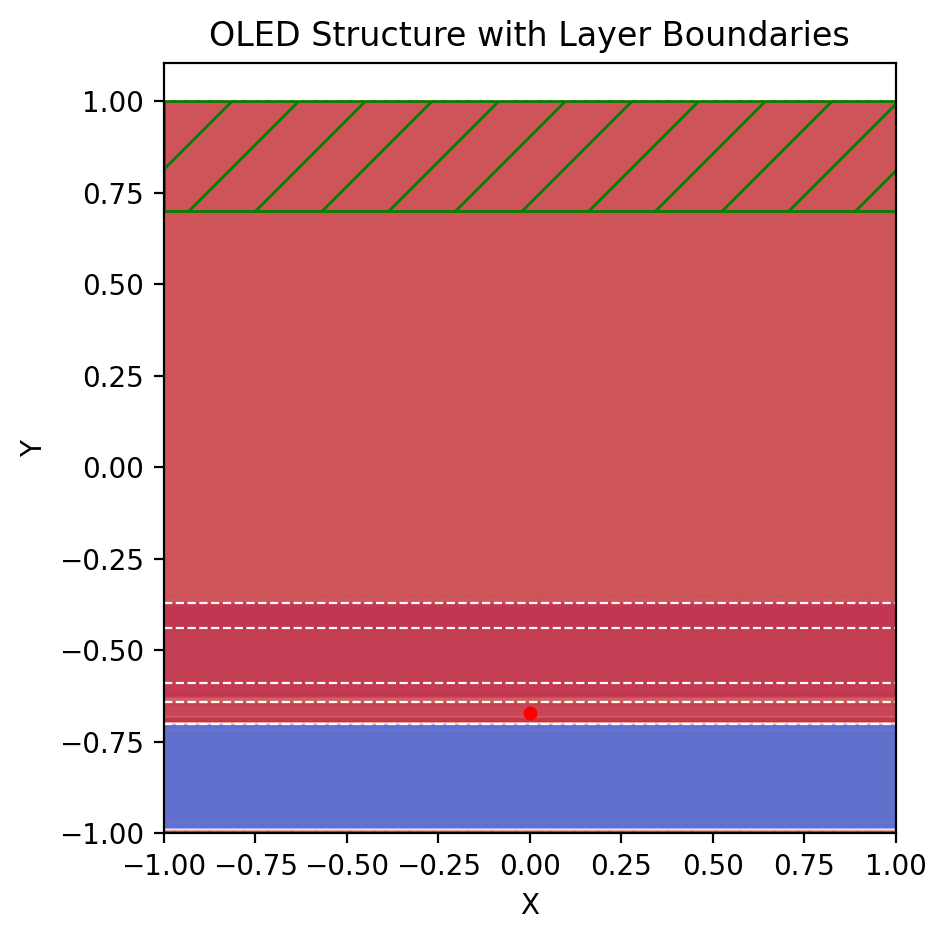

In [127]:
fig = plt.figure(dpi=200)
ax = plt.gca()
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(2, 2, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)

layer_boundaries = [
    -1.00,  # bottom of Cathode
    -0.70,  # Cathode-Alq3
    -0.64,  # Alq3-aNDP
    -0.59,  # aNDP-ITO
    -0.44,  # ITO-Cover
    -0.37,  # Cover-Glass
    1.005   # top of Glass
]

for y in layer_boundaries:
     ax.axhline(y=y, color='white', linestyle='--', linewidth=0.8)

# === 옵션 ===
plt.title("OLED Structure with Layer Boundaries")
plt.tight_layout()
plt.show()

In [128]:
# --- Flux 모니터 4면 등록 (tight box 기준) ---
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

# 박스 4면
box_power = sim.add_flux(
    fcen, df, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
    # flux x2
    mp.FluxRegion(
        center=source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
    # flux y1
    mp.FluxRegion(
        center=source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
    # flux y2
    mp.FluxRegion(
        center=source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    ),
    # mp.FluxRegion(
    #     center=source_center - mp.Vector3(0, 0, offset),
    #     size=mp.Vector3(flux_size, flux_size),
    #     # direction=mp.Y
    #     weight=-1
    # ),
    # mp.FluxRegion(
    #     center=source_center + mp.Vector3(0, 0, offset),
    #     size=mp.Vector3(flux_size, flux_size),
    #     # direction=mp.Y
    # )
)

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


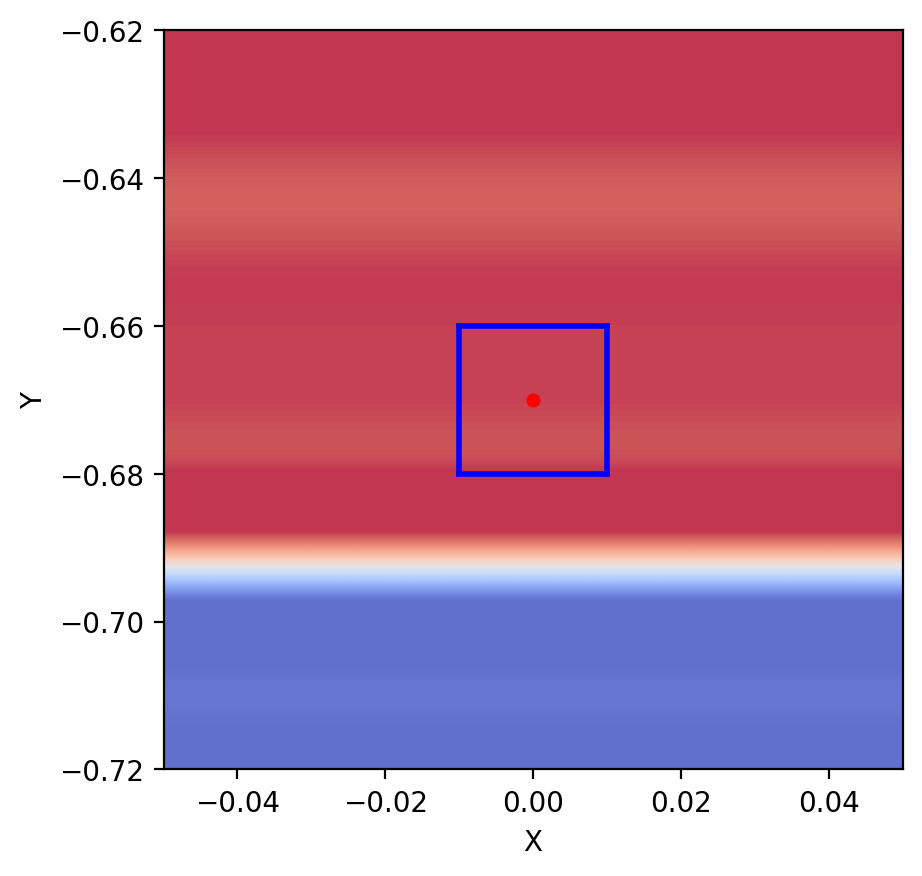

In [129]:
# center와 size를 사용해 Volume 객체 생성
vol = mp.Volume(center=mp.Vector3(0, -0.67, 0), size=mp.Vector3(2, 2, 0))
fig = plt.figure(dpi=200)
ax = plt.gca()

# 그 volume을 사용해서 2D 시각화
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,-0.67,0), size=mp.Vector3(0.1, 0.1, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)
plt.show()

In [130]:
sim.run(until=50)
net_power = mp.get_fluxes(box_power)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000397205 s
Working in 2D dimensions.
Computational cell is 30 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, 

In [22]:
for y in layer_boundaries:
     ax.axhline(y=y, color='white', linestyle='--', linewidth=0.8)

sim.plot2D(
    output_plane=mp.Volume(center = mp.Vector3(0,-0.67,0), size = mp.Vector3(0.2,0.2,0)),
    # eps_parameters={'cmap': 'magma', 'alpha': 1.0},
    ax = ax
)
center_x = 0
center_y = -0.67
size_x = 0.2
size_y = 0.2
# === 실제 확대 영역 설정 ===
ax.set_xlim(center_x - size_x/2, center_x + size_x/2)
ax.set_ylim(center_y - size_y/2, center_y + size_y/2)

plt.show()

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


In [157]:
frequencies = mp.get_flux_freqs(box_power)

wavelengths = [1/f for f in frequencies]

print("λ (μm)\t\tdipolepower_box (W)")
for i in range(nfreq):
    print(f"{wavelengths[i]:.4f}\t\t{net_power[i]:.6e}")

λ (μm)		dipolepower_box (W)
0.7005		1.285025e-05
0.6952		1.949239e-05
0.6900		2.927119e-05
0.6849		4.364822e-05
0.6799		6.449488e-05
0.6749		9.459167e-05
0.6700		1.375375e-04
0.6652		1.984399e-04
0.6605		2.839074e-04
0.6558		4.029687e-04
0.6511		5.672194e-04
0.6466		7.919821e-04
0.6421		1.096695e-03
0.6377		1.506271e-03
0.6333		2.051818e-03
0.6290		2.772058e-03
0.6247		3.714443e-03
0.6205		4.936354e-03
0.6164		6.506627e-03
0.6123		8.506043e-03
0.6083		1.102921e-02
0.6043		1.418365e-02
0.6004		1.809190e-02
0.5965		2.288826e-02
0.5927		2.872101e-02
0.5889		3.574577e-02
0.5852		4.412777e-02
0.5815		5.403093e-02
0.5779		6.562032e-02
0.5743		7.904629e-02
0.5707		9.444787e-02
0.5672		1.119319e-01
0.5638		1.315783e-01
0.5603		1.534155e-01
0.5570		1.774289e-01
0.5536		2.035338e-01
0.5503		2.315905e-01
0.5471		2.613755e-01
0.5439		2.926056e-01
0.5407		3.249101e-01
0.5375		3.578649e-01
0.5344		3.909677e-01
0.5313		4.236817e-01
0.5283		4.554150e-01
0.5253		4.855721e-01
0.5223		5.135364e-01
0.5194

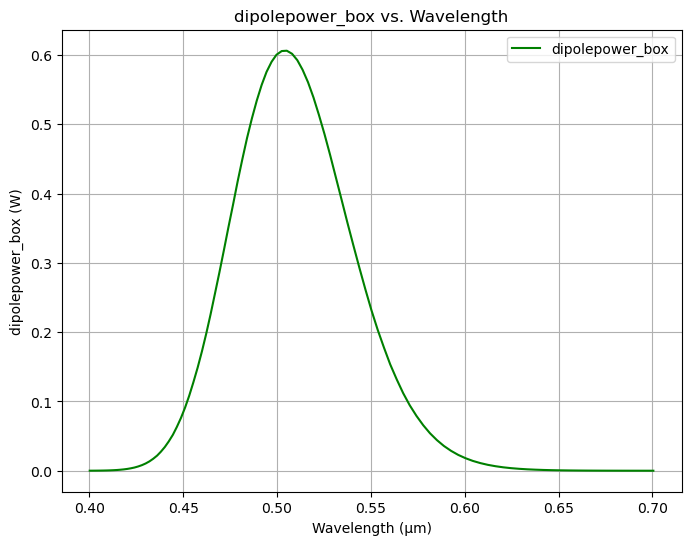

In [175]:
plt.figure(figsize=(8,6))
plt.plot(wavelengths, net_power, '-', label='dipolepower_box', color = 'green')
plt.xlabel('Wavelength (μm)')
plt.ylabel('dipolepower_box (W)')
plt.title('dipolepower_box vs. Wavelength')
# plt.ylim(-4, 14)  # y축 최소값: -4, 최대값: 14

plt.legend()
plt.grid(True)
plt.show()

In [176]:
import numpy as np

# CSV 파일 불러오기
data = np.genfromtxt("dipole_power.csv", delimiter=",", skip_header=1)

# 데이터 분리
wavelengths = data[:, 0]
source_power = data[:, 1]

# 슬라이싱: 0.5μm ≤ λ ≤ 1.0μm
mask = (wavelengths >= 0.38) & (wavelengths <= 1.0)
wavelength_sliced = wavelengths[mask]
power_sliced = source_power[mask]

# 결과 출력
print("슬라이싱된 wavelength:", wavelength_sliced)
print("슬라이싱된 power:", power_sliced)

슬라이싱된 wavelength: [0.7        0.69473684 0.68955224 0.68444444 0.67941176 0.67445255
 0.66956522 0.6647482  0.66       0.65531915 0.65070423 0.64615385
 0.64166667 0.63724138 0.63287671 0.62857143 0.62432432 0.62013423
 0.616      0.61192053 0.60789474 0.60392157 0.6        0.59612903
 0.59230769 0.58853503 0.58481013 0.58113208 0.5775     0.57391304
 0.57037037 0.56687117 0.56341463 0.56       0.55662651 0.55329341
 0.55       0.54674556 0.54352941 0.54035088 0.5372093  0.53410405
 0.53103448 0.528      0.525      0.5220339  0.51910112 0.51620112
 0.51333333 0.51049724 0.50769231 0.50491803 0.50217391 0.49945946
 0.49677419 0.49411765 0.49148936 0.48888889 0.48631579 0.48376963
 0.48125    0.47875648 0.47628866 0.47384615 0.47142857 0.46903553
 0.46666667 0.46432161 0.462      0.45970149 0.45742574 0.45517241
 0.45294118 0.45073171 0.44854369 0.44637681 0.44423077 0.44210526
 0.44       0.43791469 0.43584906 0.43380282 0.4317757  0.42976744
 0.42777778 0.42580645 0.42385321 0.42191781

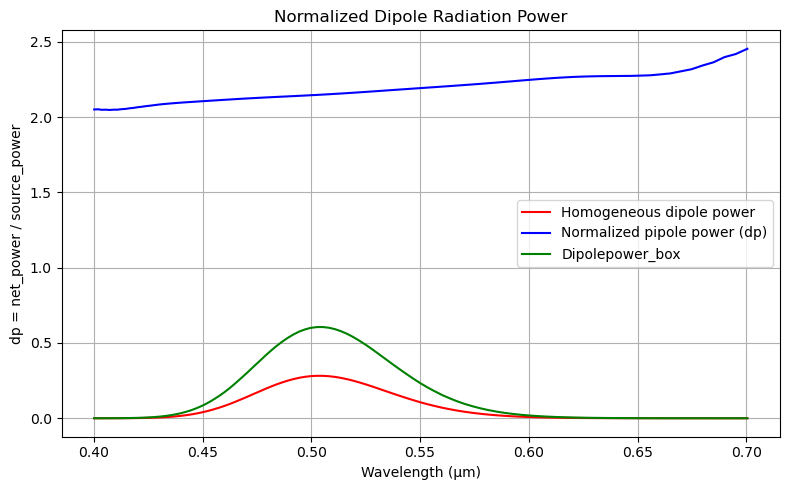

In [179]:
# source_power_interp = np.interp(wavelength_sliced, wavelengths, source_power)

dp = net_power / source_power

# 5. Plot
plt.figure(figsize=(8, 5))
plt.plot(wavelengths, source_power, '-', label='Homogeneous dipole power', color = 'red')
plt.plot(wavelengths, dp,  label='Normalized pipole power (dp)', color='blue')
plt.plot(wavelengths, net_power, '-', label='Dipolepower_box', color = 'green')

plt.xlabel("Wavelength (μm)")
plt.ylabel("dp = net_power / source_power")
plt.title("Normalized Dipole Radiation Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.yscale("log")

# plt.ylim([-4, 14])
# plt.xlim([0.68, 0.72])
plt.show()

sim.add_flux(...) → Fourier-transformed field 데이터를 누적 시작

sim.get_fluxes(flux_obj) → 누적된 데이터를 바탕으로 power 계산

sim.get_dft_array(...) → 실제 E, H field의 Fourier transformed 값을 배열로 받을 수 있음

→ 파장이 길어질수록 source dipole의 방사효율은 줄어들지만, 시스템은 에너지를 더 잘 전달함 → dp 증가.

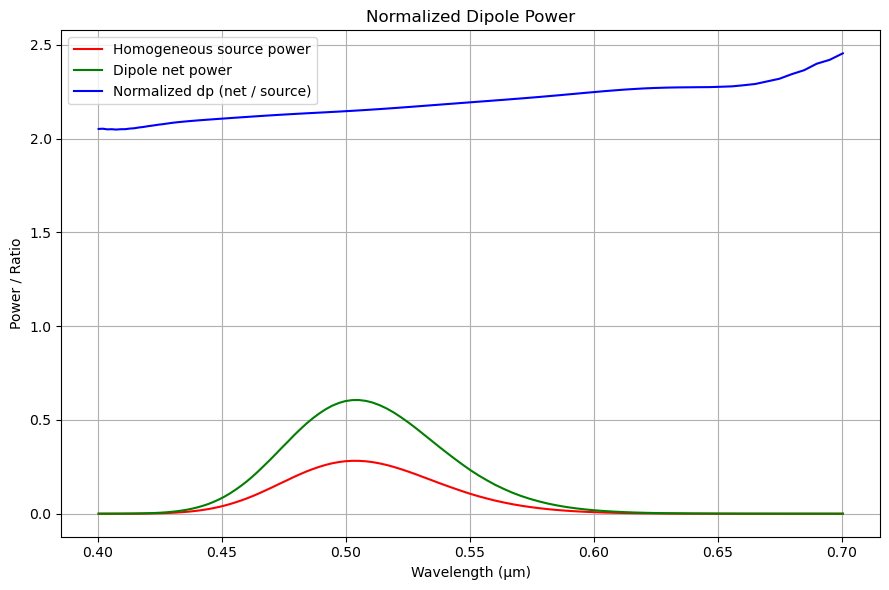

In [178]:
import numpy as np
import matplotlib.pyplot as plt

# 1. wavelength (공통)
wavelengths = np.array([
    0.7005, 0.6952, 0.6900, 0.6849, 0.6799, 0.6749, 0.6700, 0.6652, 0.6605, 0.6558,
    0.6511, 0.6466, 0.6421, 0.6377, 0.6333, 0.6290, 0.6247, 0.6205, 0.6164, 0.6123,
    0.6083, 0.6043, 0.6004, 0.5965, 0.5927, 0.5889, 0.5852, 0.5815, 0.5779, 0.5743,
    0.5707, 0.5672, 0.5638, 0.5603, 0.5570, 0.5536, 0.5503, 0.5471, 0.5439, 0.5407,
    0.5375, 0.5344, 0.5313, 0.5283, 0.5253, 0.5223, 0.5194, 0.5165, 0.5136, 0.5108,
    0.5080, 0.5052, 0.5025, 0.4997, 0.4971, 0.4944, 0.4918, 0.4892, 0.4866, 0.4840,
    0.4815, 0.4790, 0.4766, 0.4741, 0.4717, 0.4693, 0.4669, 0.4646, 0.4623, 0.4600,
    0.4577, 0.4554, 0.4532, 0.4510, 0.4488, 0.4466, 0.4445, 0.4423, 0.4402, 0.4381,
    0.4361, 0.4340, 0.4320, 0.4300, 0.4280, 0.4260, 0.4241, 0.4221, 0.4202, 0.4183,
    0.4164, 0.4146, 0.4127, 0.4109, 0.4091, 0.4073, 0.4055, 0.4037, 0.4019, 0.4002
])

# 2. net power
net_power = np.array([
    1.285025e-05, 1.949239e-05, 2.927119e-05, 4.364822e-05, 6.449488e-05,
    9.459167e-05, 1.375375e-04, 1.984399e-04, 2.839074e-04, 4.029687e-04,
    5.672194e-04, 7.919821e-04, 1.096695e-03, 1.506271e-03, 2.051818e-03,
    2.772058e-03, 3.714443e-03, 4.936354e-03, 6.506627e-03, 8.506043e-03,
    1.102921e-02, 1.418365e-02, 1.809190e-02, 2.288826e-02, 2.872101e-02,
    3.574577e-02, 4.412777e-02, 5.403093e-02, 6.562032e-02, 7.904629e-02,
    9.444787e-02, 1.119319e-01, 1.315783e-01, 1.534155e-01, 1.774289e-01,
    2.035338e-01, 2.315905e-01, 2.613755e-01, 2.926056e-01, 3.249101e-01,
    3.578649e-01, 3.909677e-01, 4.236817e-01, 4.554150e-01, 4.855721e-01,
    5.135364e-01, 5.387272e-01, 5.605827e-01, 5.786174e-01, 5.924036e-01,
    6.016238e-01, 6.060482e-01, 6.055776e-01, 6.002151e-01, 5.900965e-01,
    5.754564e-01, 5.566453e-01, 5.340920e-01, 5.083088e-01, 4.798530e-01,
    4.493240e-01, 4.173282e-01, 3.844709e-01, 3.513287e-01, 3.184407e-01,
    2.862901e-01, 2.552973e-01, 2.258126e-01, 1.981117e-01, 1.723987e-01,
    1.488046e-01, 1.273977e-01, 1.081841e-01, 9.112337e-02, 7.612922e-02,
    6.308690e-02, 5.185373e-02, 4.227562e-02, 3.418606e-02, 2.742087e-02,
    2.181503e-02, 1.721519e-02, 1.347402e-02, 1.046130e-02, 8.052671e-03,
    6.150423e-03, 4.660056e-03, 3.501944e-03, 2.610362e-03, 1.930052e-03,
    1.415454e-03, 1.029722e-03, 7.429953e-04, 5.318211e-04, 3.775391e-04,
    2.658786e-04, 1.856871e-04, 1.286506e-04, 8.838119e-05, 6.023383e-05
])

# 3. source power
source_power = np.array([
    5.235750e-06, 8.055623e-06, 1.220064e-05, 1.845975e-05, 2.752246e-05,
    4.079269e-05, 5.967359e-05, 8.661311e-05, 1.242860e-04, 1.768702e-04,
    2.492034e-04, 3.482369e-04, 4.823048e-04, 6.626138e-04, 9.028367e-04,
    1.220359e-03, 1.636496e-03, 2.177032e-03, 2.873457e-03, 3.762099e-03,
    4.886890e-03, 6.296151e-03, 8.047511e-03, 1.020116e-02, 1.282773e-02,
    1.599661e-02, 1.978773e-02, 2.427361e-02, 2.953607e-02, 3.564069e-02,
    4.265981e-02, 5.063829e-02, 5.962427e-02, 6.962568e-02, 8.065025e-02,
    9.265279e-02, 1.055858e-01, 1.193384e-01, 1.337982e-01, 1.487837e-01,
    1.641174e-01, 1.795527e-01, 1.948587e-01, 2.097425e-01, 2.239434e-01,
    2.371531e-01, 2.491144e-01, 2.595418e-01, 2.682200e-01, 2.749246e-01,
    2.795173e-01, 2.818673e-01, 2.819372e-01, 2.797078e-01, 2.752512e-01,
    2.686603e-01, 2.601070e-01, 2.497791e-01, 2.379229e-01, 2.247903e-01,
    2.106669e-01, 1.958308e-01, 1.805689e-01, 1.651483e-01, 1.498234e-01,
    1.348206e-01, 1.203379e-01, 1.065417e-01, 9.356179e-02, 8.149838e-02,
    7.041291e-02, 6.034322e-02, 5.129184e-02, 4.324598e-02, 3.616419e-02,
    2.999851e-02, 2.468028e-02, 2.014218e-02, 1.630378e-02, 1.309189e-02,
    1.042649e-02, 8.238348e-03, 6.455885e-03, 5.019693e-03, 3.870720e-03,
    2.961778e-03, 2.247314e-03, 1.692222e-03, 1.263352e-03, 9.360593e-04,
    6.874411e-04, 5.010806e-04, 3.618812e-04, 2.594241e-04, 1.841780e-04,
    1.298240e-04, 9.058239e-05, 6.278443e-05, 4.305834e-05, 2.936470e-05
])

# 4. 정규화 (dp 계산)
dp = net_power / source_power

# 5. Plot
plt.figure(figsize=(9, 6))
plt.plot(wavelengths, source_power, label='Homogeneous source power', color='red')
plt.plot(wavelengths, net_power, label='Dipole net power', color='green')
plt.plot(wavelengths, dp, label='Normalized dp (net / source)', color='blue')
plt.xlabel("Wavelength (μm)")
plt.ylabel("Power / Ratio")
plt.title("Normalized Dipole Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
